In [12]:
import os, numpy as np, torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    DataCollatorWithPadding, get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [13]:
ds = load_dataset("wics/strategy-qa", revision="refs/convert/parquet")

base = ds["test"]
tmp = base.train_test_split(test_size=0.2, seed=42)
train_valid = tmp["train"]
valid_test = tmp["test"].train_test_split(test_size=0.5, seed=42)

train_ds, dev_ds, test_ds = train_valid, valid_test["train"], valid_test["test"]
len(train_ds), len(dev_ds), len(test_ds)


(1832, 229, 229)

In [14]:
model_id = "answerdotai/ModernBERT-base"  
tokenizer = AutoTokenizer.from_pretrained(model_id)

def preprocess(batch):
    labels = [1 if a else 0 for a in batch["answer"]]
    tok = tokenizer(batch["question"], truncation=True, padding=False, max_length=256)
    tok["labels"] = labels
    return tok

train_tok = train_ds.map(preprocess, batched=True, remove_columns=train_ds.column_names)
dev_tok   = dev_ds.map(preprocess,   batched=True, remove_columns=dev_ds.column_names)
test_tok  = test_ds.map(preprocess,  batched=True, remove_columns=test_ds.column_names)

collator = DataCollatorWithPadding(tokenizer)

bsz = 32
train_loader = DataLoader(train_tok, batch_size=bsz, shuffle=True,  collate_fn=collator)
dev_loader   = DataLoader(dev_tok,   batch_size=bsz, shuffle=False, collate_fn=collator)
test_loader  = DataLoader(test_tok,  batch_size=bsz, shuffle=False, collate_fn=collator)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Map: 100%|██████████| 229/229 [00:00<00:00, 15661.36 examples/s]


device(type='cuda')

In [15]:
config = AutoConfig.from_pretrained(model_id, num_labels=2)
model  = AutoModelForSequenceClassification.from_pretrained(model_id, config=config).to(device)

for p in model.classifier.parameters():
    p.requires_grad = False

lora_cfg = LoraConfig(
    r=1, lora_alpha=1, lora_dropout=0.0,
    target_modules=["out_proj", "wo", "dense"],  
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_cfg)

LORA_LAYER_ID = "layer.16"
for name, param in model.named_parameters():
    if "lora_" in name:
        if LORA_LAYER_ID not in name:
            param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.4f}%)")


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 1,538 / 149,609,476 (0.0010%)


In [16]:
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(-1)
    return (preds == labels).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    tot_acc, tot_n = 0.0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        acc = accuracy_from_logits(out.logits, batch["labels"])
        n = batch["labels"].size(0)
        tot_acc += acc * n
        tot_n   += n
    return tot_acc / tot_n


In [ ]:
epochs = 3
lr = 2e-3  # LoRA r=1 on single Wo can use similar LR
optim = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=0.0)

num_training_steps = epochs * len(train_loader)
sched = get_linear_schedule_with_warmup(optim, num_warmup_steps=int(0.06 * num_training_steps),
                                        num_training_steps=num_training_steps)

train_hist, dev_hist = [], []
best_dev, best_path = -1.0, "modernbert_lora_best.pt"

for ep in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}")
    for batch in pbar:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step(); sched.step()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    tr_acc  = evaluate(model, train_loader)
    dev_acc = evaluate(model, dev_loader)
    train_hist.append(tr_acc); dev_hist.append(dev_acc)
    print(f"Epoch {ep}: train_acc={tr_acc:.4f}  dev_acc={dev_acc:.4f}")

    if dev_acc > best_dev:
        best_dev = dev_acc
        torch.save(model.state_dict(), best_path)
        print(f"New best dev={best_dev:.4f} → saved {best_path}")


Epoch 1/8: 100%|██████████| 58/58 [00:01<00:00, 52.51it/s, loss=0.6114]


Epoch 1: train_acc=0.6053  dev_acc=0.5371
New best dev=0.5371 → saved modernbert_lora_best.pt


Epoch 2/8: 100%|██████████| 58/58 [00:00<00:00, 59.24it/s, loss=0.8343]


Epoch 2: train_acc=0.6507  dev_acc=0.5895
New best dev=0.5895 → saved modernbert_lora_best.pt


Epoch 3/8: 100%|██████████| 58/58 [00:00<00:00, 58.84it/s, loss=0.4096]


Epoch 3: train_acc=0.6681  dev_acc=0.5371


Epoch 4/8: 100%|██████████| 58/58 [00:00<00:00, 59.19it/s, loss=0.5893]


Epoch 4: train_acc=0.6807  dev_acc=0.5983
New best dev=0.5983 → saved modernbert_lora_best.pt


Epoch 5/8: 100%|██████████| 58/58 [00:00<00:00, 59.87it/s, loss=0.6302]


Epoch 5: train_acc=0.6763  dev_acc=0.5852


Epoch 6/8: 100%|██████████| 58/58 [00:00<00:00, 58.16it/s, loss=0.7090]


Epoch 6: train_acc=0.6927  dev_acc=0.5808


Epoch 7/8: 100%|██████████| 58/58 [00:00<00:00, 60.27it/s, loss=0.5692]


Epoch 7: train_acc=0.7151  dev_acc=0.5590


Epoch 8/8: 100%|██████████| 58/58 [00:00<00:00, 59.94it/s, loss=0.4040]


Epoch 8: train_acc=0.7238  dev_acc=0.5502


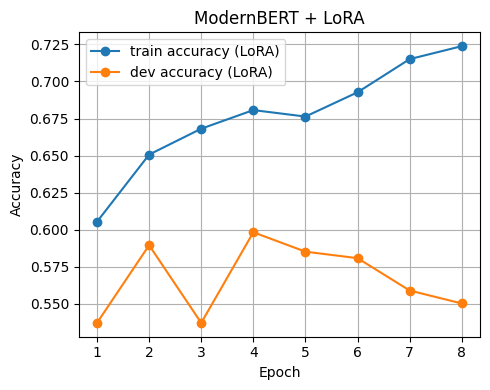

In [18]:
epochs_axis = range(1, len(dev_hist)+1)
plt.figure(figsize=(5,4))
plt.plot(epochs_axis, train_hist, "-o", label="train accuracy (LoRA)")
plt.plot(epochs_axis, dev_hist,   "-o", label="dev accuracy (LoRA)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("ModernBERT + LoRA")
plt.grid(True); plt.legend(); plt.tight_layout()


In [19]:
model.load_state_dict(torch.load(best_path, map_location=device))
model.to(device)
test_acc = evaluate(model, test_loader)
print({"lora_best_dev_accuracy": best_dev, "lora_test_accuracy": test_acc})

C:\Users\gabri\AppData\Local\Temp\ipykernel_896\4073783681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=devic

{'lora_best_dev_accuracy': 0.5982532756297348, 'lora_test_accuracy': 0.5807860262659439}
